# 1. Importing modules and functions

In [3]:
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import MACCSkeys
from copy import deepcopy
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from padelpy import from_sdf
import shap
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
def convert_smi_to_canon_smi(smi):
    
    try:
        canon_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi),isomericSmiles = False)
    except:
        canon_smi='wrong_smiles'
    return canon_smi

In [5]:
def standart(smi):
    global m
    if smi!='wrong_smiles':
        try:
            smiles=standardize_smiles(smi)
            m = Chem.MolFromSmiles(smi)
        except:
            smi='error kekule'
    else:
        m = 'check the smiles'
    return m

## Load data and curation work set

In [7]:
# Set file path
df_ws=pd.read_csv('datasets/rat_oral_LD50_WS.csv')
df_ws

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_oral_LD50
0,TOX-8327,12283,"6-methyl-1H-pyrimidine-2,4-dione",Cc1cc(=O)[nH]c(=O)[nH]1,Cc1cc(=O)[nH]c(=O)[nH]1,SHVCSCWHWMSGTE-UHFFFAOYSA-N,0.291207
1,TOX-27223,34042,"4-(1,3-benzodioxol-5-yl)butan-2-ylhydrazine",CC(CCc1ccc2c(c1)OCO2)NN,CC(CCc1ccc2c(c1)OCO2)NN,IBWPUTAKVGZXRB-UHFFFAOYSA-N,0.440661
2,TOX-5723,8058,hexane,CCCCCC,CCCCCC,VLKZOEOYAKHREP-UHFFFAOYSA-N,0.537456
3,TOX-72438,94201,"bis(2-ethylhexyl) cyclohexene-1,2-dicarboxylate",CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,ZVPBHZIVOWGPMT-UHFFFAOYSA-N,0.539248
4,TOX-4318,1030,"propane-1,2-diol",CC(O)CO,CC(O)CO,DNIAPMSPPWPWGF-UHFFFAOYSA-N,0.580326
...,...,...,...,...,...,...,...
7869,TOX-34548,39729,"2,3,7,8-tetrabromodibenzo-p-dioxin",Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,JZLQUWSWOJPCAK-UHFFFAOYSA-N,6.698777
7870,TOX-2774,3890,"propan-2-yl 7-[3,5-dihydroxy-2-(3-hydroxy-5-ph...",CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,GGXICVAJURFBLW-UHFFFAOYSA-N,6.937118
7871,TOX-57286,3323,"5-[2-[7a-methyl-1-[7,7,7-trifluoro-6-hydroxy-6...",C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,XPYGGHVSFMUHLH-UHFFFAOYSA-N,7.099681
7872,TOX-6661,9426,"2-[(6,7-dimethoxy-1,2,3,4-tetrahydroisoquinoli...",CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC1NCCc2cc(OC)c(...,CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC1NCCc2cc(OC)c(...,AUVVAXYIELKVAI-UHFFFAOYSA-N,7.602647


##  Standardization  for work set

In [9]:
df_ws["Molecule"] = df_ws.apply(lambda x: standart(x.SMILES), axis=1)
moldf_ws=df_ws[df_ws['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ws), 'molecules')

[07:45:05] Unusual charge on atom 8 number of radical electrons set to zero
[07:45:05] Unusual charge on atom 0 number of radical electrons set to zero
[07:45:05] Unusual charge on atom 16 number of radical electrons set to zero
[07:45:05] Unusual charge on atom 16 number of radical electrons set to zero


Kept data:  7874 molecules


In [10]:
moldf_ws

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_oral_LD50,Molecule
0,TOX-8327,12283,"6-methyl-1H-pyrimidine-2,4-dione",Cc1cc(=O)[nH]c(=O)[nH]1,Cc1cc(=O)[nH]c(=O)[nH]1,SHVCSCWHWMSGTE-UHFFFAOYSA-N,0.291207,<rdkit.Chem.rdchem.Mol object at 0x00000170EA0...
1,TOX-27223,34042,"4-(1,3-benzodioxol-5-yl)butan-2-ylhydrazine",CC(CCc1ccc2c(c1)OCO2)NN,CC(CCc1ccc2c(c1)OCO2)NN,IBWPUTAKVGZXRB-UHFFFAOYSA-N,0.440661,<rdkit.Chem.rdchem.Mol object at 0x00000170EA0...
2,TOX-5723,8058,hexane,CCCCCC,CCCCCC,VLKZOEOYAKHREP-UHFFFAOYSA-N,0.537456,<rdkit.Chem.rdchem.Mol object at 0x00000170EA0...
3,TOX-72438,94201,"bis(2-ethylhexyl) cyclohexene-1,2-dicarboxylate",CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,ZVPBHZIVOWGPMT-UHFFFAOYSA-N,0.539248,<rdkit.Chem.rdchem.Mol object at 0x00000170EA0...
4,TOX-4318,1030,"propane-1,2-diol",CC(O)CO,CC(O)CO,DNIAPMSPPWPWGF-UHFFFAOYSA-N,0.580326,<rdkit.Chem.rdchem.Mol object at 0x00000170EA0...
...,...,...,...,...,...,...,...,...
7869,TOX-34548,39729,"2,3,7,8-tetrabromodibenzo-p-dioxin",Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,JZLQUWSWOJPCAK-UHFFFAOYSA-N,6.698777,<rdkit.Chem.rdchem.Mol object at 0x00000170E9A...
7870,TOX-2774,3890,"propan-2-yl 7-[3,5-dihydroxy-2-(3-hydroxy-5-ph...",CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,GGXICVAJURFBLW-UHFFFAOYSA-N,6.937118,<rdkit.Chem.rdchem.Mol object at 0x00000170E9A...
7871,TOX-57286,3323,"5-[2-[7a-methyl-1-[7,7,7-trifluoro-6-hydroxy-6...",C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,XPYGGHVSFMUHLH-UHFFFAOYSA-N,7.099681,<rdkit.Chem.rdchem.Mol object at 0x00000170E9A...
7872,TOX-6661,9426,"2-[(6,7-dimethoxy-1,2,3,4-tetrahydroisoquinoli...",CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC1NCCc2cc(OC)c(...,CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC1NCCc2cc(OC)c(...,AUVVAXYIELKVAI-UHFFFAOYSA-N,7.602647,<rdkit.Chem.rdchem.Mol object at 0x00000170E9A...


In [11]:
y_tr=moldf_ws.rat_oral_LD50
y_tr

0       0.291207
1       0.440661
2       0.537456
3       0.539248
4       0.580326
          ...   
7869    6.698777
7870    6.937118
7871    7.099681
7872    7.602647
7873    9.541127
Name: rat_oral_LD50, Length: 7874, dtype: float64

In [12]:
moldf_ws=moldf_ws.Molecule

##  Load data and curation test set

In [14]:
df_ts=pd.read_csv('datasets/rat_oral_LD50_TS.csv')
df_ts

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_oral_LD50
0,TOX-17137,297,methane,C,C,VNWKTOKETHGBQD-UHFFFAOYSA-N,0.017765
1,TOX-107853,17827,2-(cyclohexylamino)ethanol,OCCNC1CCCCC1,OCCNC1CCCCC1,MGUMZJAQENFQKN-UHFFFAOYSA-N,0.572835
2,TOX-44620,974,oxamic acid,NC(=O)C(=O)O,NC(=O)C(=O)O,SOWBFZRMHSNYGE-UHFFFAOYSA-N,0.624488
3,TOX-11368,62433,pentyl pentanoate,CCCCCOC(=O)CCCC,CCCCCOC(=O)CCCC,FGPPDYNPZTUNIU-UHFFFAOYSA-N,0.686956
4,TOX-7935,11429,"butane-1,2-diol",CCC(O)CO,CCC(O)CO,BMRWNKZVCUKKSR-UHFFFAOYSA-N,0.750711
...,...,...,...,...,...,...,...
1964,TOX-31209,123453,"N-(2,8,9-trioxa-5-aza-1-silabicyclo[3.3.3]unde...",c1ccc(NC[Si]23OCCN(CCO2)CCO3)cc1,c1ccc(NC[Si]23OCCN(CCO2)CCO3)cc1,YGHSPISFNKUQEY-UHFFFAOYSA-N,5.931904
1965,TOX-63960,91771,"3-[3-[4-(4-bromophenyl)phenyl]-1,2,3,4-tetrahy...",O=c1sc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,O=c1sc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,VSVAQRUUFVBBFS-UHFFFAOYSA-N,5.991624
1966,TOX-33005,38439,"1,2,3,7,8-pentachlorodibenzo-p-dioxin",Clc1cc2c(cc1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2,Clc1cc2c(cc1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2,FSPZPQQWDODWAU-UHFFFAOYSA-N,6.238094
1967,TOX-24685,198007,3-ethyl-N-[methoxy(methylsulfanyl)phosphoryl]-...,CCN1CC(C)OC1=NP(=O)(OC)SC,CCN1CC(C)OC1=NP(=O)(OC)SC,JCYANUVOCLKHHY-UHFFFAOYSA-N,6.401876


##  Standardization  for test set

In [16]:
df_ts["Molecule"] = df_ts.apply(lambda x: standart(x.SMILES), axis=1)
moldf_ts=df_ts[df_ts['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  1969 molecules


In [17]:
moldf_ts

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_oral_LD50,Molecule
0,TOX-17137,297,methane,C,C,VNWKTOKETHGBQD-UHFFFAOYSA-N,0.017765,<rdkit.Chem.rdchem.Mol object at 0x00000170EA1...
1,TOX-107853,17827,2-(cyclohexylamino)ethanol,OCCNC1CCCCC1,OCCNC1CCCCC1,MGUMZJAQENFQKN-UHFFFAOYSA-N,0.572835,<rdkit.Chem.rdchem.Mol object at 0x00000170EA1...
2,TOX-44620,974,oxamic acid,NC(=O)C(=O)O,NC(=O)C(=O)O,SOWBFZRMHSNYGE-UHFFFAOYSA-N,0.624488,<rdkit.Chem.rdchem.Mol object at 0x00000170EA1...
3,TOX-11368,62433,pentyl pentanoate,CCCCCOC(=O)CCCC,CCCCCOC(=O)CCCC,FGPPDYNPZTUNIU-UHFFFAOYSA-N,0.686956,<rdkit.Chem.rdchem.Mol object at 0x00000170EA1...
4,TOX-7935,11429,"butane-1,2-diol",CCC(O)CO,CCC(O)CO,BMRWNKZVCUKKSR-UHFFFAOYSA-N,0.750711,<rdkit.Chem.rdchem.Mol object at 0x00000170EA1...
...,...,...,...,...,...,...,...,...
1964,TOX-31209,123453,"N-(2,8,9-trioxa-5-aza-1-silabicyclo[3.3.3]unde...",c1ccc(NC[Si]23OCCN(CCO2)CCO3)cc1,c1ccc(NC[Si]23OCCN(CCO2)CCO3)cc1,YGHSPISFNKUQEY-UHFFFAOYSA-N,5.931904,<rdkit.Chem.rdchem.Mol object at 0x00000170E9C...
1965,TOX-63960,91771,"3-[3-[4-(4-bromophenyl)phenyl]-1,2,3,4-tetrahy...",O=c1sc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,O=c1sc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,VSVAQRUUFVBBFS-UHFFFAOYSA-N,5.991624,<rdkit.Chem.rdchem.Mol object at 0x00000170E9C...
1966,TOX-33005,38439,"1,2,3,7,8-pentachlorodibenzo-p-dioxin",Clc1cc2c(cc1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2,Clc1cc2c(cc1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2,FSPZPQQWDODWAU-UHFFFAOYSA-N,6.238094,<rdkit.Chem.rdchem.Mol object at 0x00000170E9C...
1967,TOX-24685,198007,3-ethyl-N-[methoxy(methylsulfanyl)phosphoryl]-...,CCN1CC(C)OC1=NP(=O)(OC)SC,CCN1CC(C)OC1=NP(=O)(OC)SC,JCYANUVOCLKHHY-UHFFFAOYSA-N,6.401876,<rdkit.Chem.rdchem.Mol object at 0x00000170E9C...


In [18]:
y_ts=moldf_ts.rat_oral_LD50
y_ts

0       0.017765
1       0.572835
2       0.624488
3       0.686956
4       0.750711
          ...   
1964    5.931904
1965    5.991624
1966    6.238094
1967    6.401876
1968    7.206791
Name: rat_oral_LD50, Length: 1969, dtype: float64

In [19]:
moldf_ts=moldf_ts.Molecule

# Calculation RDKit_2D descriptors for work set

In [21]:
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
header = calc.GetDescriptorNames()

In [22]:
descr_tr= []
for m in moldf_ws:
    descr_tr.append(calc.CalcDescriptors(m))
x_tr = np.asarray(descr_tr)

In [23]:
df_RDKit_2D = pd.DataFrame(x_tr,columns=header)

In [24]:
df_RDKit_2D.head(2)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.435556,10.435556,0.364583,-0.458333,0.485781,9.444444,126.115,120.067,126.042927,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.331682,5.331682,0.329095,0.329095,0.576369,15.333333,208.261,192.133,208.121178,82.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df_RDKit_2D.isna().mean().sort_values(ascending=False).head(15)

BCUT2D_MWHI            0.019939
BCUT2D_CHGLO           0.019939
BCUT2D_MWLOW           0.019939
BCUT2D_LOGPHI          0.019939
BCUT2D_LOGPLOW         0.019939
BCUT2D_MRHI            0.019939
BCUT2D_MRLOW           0.019939
BCUT2D_CHGHI           0.019939
MaxPartialCharge       0.018796
MinPartialCharge       0.018796
MaxAbsPartialCharge    0.018796
MinAbsPartialCharge    0.018796
fr_Ndealkylation1      0.000000
fr_Ndealkylation2      0.000000
fr_N_O                 0.000000
dtype: float64

In [26]:
df_RDKit_2D=df_RDKit_2D.dropna(axis=1)
df_RDKit_2D

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.435556,10.435556,0.364583,-0.458333,0.485781,9.444444,126.115,120.067,126.042927,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.331682,5.331682,0.329095,0.329095,0.576369,15.333333,208.261,192.133,208.121178,82.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.231806,2.231806,1.355000,1.355000,0.462954,9.000000,86.178,72.066,86.109550,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
3,12.654921,12.654921,0.305905,-0.305905,0.320912,16.571429,394.596,352.260,394.308310,162.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,8.111111,8.111111,0.138889,-0.560185,0.435835,15.000000,76.095,68.031,76.052429,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,5.822407,5.822407,0.686849,0.686849,0.345378,12.222222,499.778,495.746,495.694478,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7870,11.543842,11.543842,0.006523,-0.513401,0.247186,24.709677,432.601,392.281,432.287574,174.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7871,13.011064,13.011064,0.077001,-5.771605,0.335502,35.361111,524.586,486.282,524.272514,206.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7872,5.676825,5.676825,0.345019,0.345019,0.605684,25.742857,480.649,440.329,480.298808,190.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
x_tr= df_RDKit_2D.to_numpy ()

In [28]:
# Data Standardization
from sklearn.preprocessing import StandardScaler
scale = StandardScaler().fit(x_tr)
x_tr = scale.transform(x_tr)


In [29]:
x_tr.shape

(7874, 198)

In [30]:
savetxt('models/RDKiT/x_tr_RDKiT.csv', x_tr, delimiter=',')

# Calculation RDKit_2D descriptors for test set

In [32]:
descr_ts = []
for m in moldf_ts:
    descr_ts.append(calc.CalcDescriptors(m))
x_ts = np.asarray(descr_ts)

In [33]:
x_ts.shape

(1969, 210)

In [34]:
df_RDKit_2D_ts = pd.DataFrame(x_ts,columns=header)
df_RDKit_2D_ts=df_RDKit_2D_ts.dropna(axis=1)
df_RDKit_2D_ts

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.000000,0.000000,0.000000,0.000000,0.359785,0.000000,16.043,12.011,16.031300,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.534403,8.534403,0.274306,0.274306,0.614964,21.300000,143.230,126.094,143.131014,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.321759,9.321759,1.324074,-1.601852,0.356333,7.333333,89.050,86.026,89.011293,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.942870,10.942870,0.034303,-0.034303,0.435733,9.833333,172.268,152.108,172.146330,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
4,8.416667,8.416667,0.114583,-0.509259,0.490543,14.500000,90.122,80.042,90.068080,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,5.953412,5.953412,0.635926,-2.547894,0.835383,31.263158,280.400,260.240,280.124319,104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1965,13.286891,13.286891,0.048852,-0.134763,0.250694,17.285714,539.494,516.310,538.060213,172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1966,6.073557,6.073557,0.181379,0.181379,0.410021,12.263158,356.419,353.395,353.857568,98.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1967,11.921396,11.921396,0.093391,-2.969414,0.717823,27.866667,252.276,235.140,252.069750,88.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
x_ts= df_RDKit_2D_ts.to_numpy ()

In [36]:
x_ts = scale.transform(x_ts)

In [67]:
x_ts.shape

(1969, 198)

# CatBoostRegressor

In [73]:
cv=KFold(n_splits=5, random_state=42, shuffle=True)

In [44]:
%%time
model = CatBoostRegressor()
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [100,500, 1000]
              }

grid = GridSearchCV(estimator=model, param_grid = parameters, n_jobs=-1, cv = cv)
grid.fit(x_tr, y_tr, verbose=False)

CPU times: total: 6min 47s
Wall time: 1h 8min 30s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000023AB7BAFC50>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [100, 500, 1000],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [50]:
best_CatBR = grid.best_estimator_

In [51]:
grid.best_params_

{'depth': 8, 'iterations': 1000, 'learning_rate': 0.1}

In [52]:
y_pred_ws_GBR = best_CatBR.predict(x_tr)

In [53]:
R2_WS = round(r2_score(y_tr, y_pred_ws_GBR), 2)
R2_WS

0.97

In [54]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_GBR)), 2)
RMSE_WS

0.15

In [69]:
params={'verbose': False}

In [75]:
%%time
y_pred_CV_CatBR = cross_val_predict(best_CatBR, x_tr, y_tr, cv=cv, fit_params=params)

CPU times: total: 26min 56s
Wall time: 2min 1s


In [76]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_CatBR), 2)
Q2_CV

0.58

In [77]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_CatBR)), 2)
RMSE_CV

0.58

# save the model to disk

In [138]:
pickle.dump(best_CatBR, open('Models/RDKiT/Toxicity_CatBoost_RDKiT.pkl', 'wb'))

# load the model from disk

In [69]:
best_CatBR = pickle.load(open('Models/RDKiT/Toxicity_CatBoost_RDKiT.pkl', 'rb'))

# Prediction for test set's molecules

In [72]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [74]:
y_pred_GBR = best_CatBR.predict(x_ts)

In [76]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.6

In [78]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.57

# Calculate Feature Importance

In [87]:
data = pd.DataFrame({'feature_importance': best_CatBR.get_feature_importance(), 
              'feature_names': df_RDKit_2D.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

<Axes: ylabel='feature_names'>

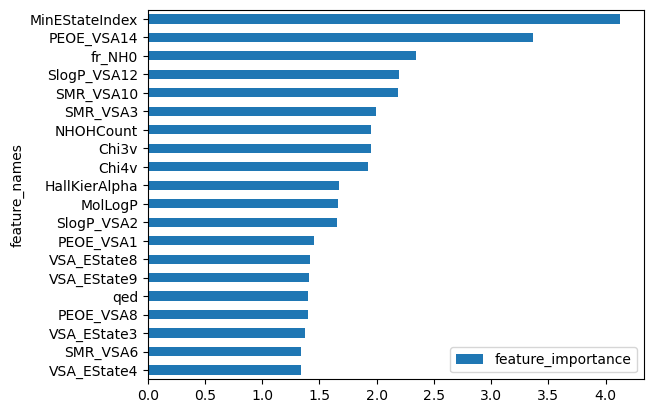

In [89]:
data[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

# Y-randomization GradientBoostingRegressor model

In [78]:
params={'verbose': False}

In [79]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_CatBR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           fit_params=params,
                                                           random_state=42)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

True score =  0.58 
Y-randomization =  -0.14 
p-value =  0.0196


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [85]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [86]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7864,7865,7866,7867,7868,7869,7870,7871,7872,7873
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.564634,6.786168,3.697606,4.651314,1.779662,2.625592,4.569777,5.573458,1.292887,3.514202,...,2.217837,3.928712,4.914064,8.399861,2.484646,9.783295,8.456615,13.534068,10.096812,9.783039
2,3.249253,7.875638,3.854963,4.867033,2.296633,2.976569,4.900345,5.719847,1.377127,4.728705,...,3.470451,4.314390,10.512851,8.516621,5.719888,10.797580,8.793078,13.568486,10.242634,9.836699
3,4.338933,8.160106,3.941355,5.354989,2.505008,3.789611,5.157831,5.869029,1.718737,5.212587,...,3.485316,4.378597,10.644041,8.766701,8.399861,10.822072,8.855505,13.600311,10.363007,10.910876
4,4.398145,8.287079,3.966521,5.693967,3.039171,3.952668,5.733284,6.090124,2.046153,5.764359,...,3.556975,4.512706,11.196340,10.898507,9.016130,11.026720,9.330314,14.070976,10.947917,11.201504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,75.286763,73.508363,76.743550,70.229948,75.322924,74.683866,73.394957,73.951499,73.823109,76.621513,...,73.115011,71.349319,68.976267,67.620439,69.248836,72.958329,68.656277,68.096628,67.604262,68.746942
7870,77.359288,74.069358,78.603548,71.825880,77.657036,76.571494,76.231182,74.208455,76.351777,78.574907,...,76.280284,74.515635,69.456295,68.207019,71.258406,72.989074,68.743412,68.701544,70.665615,70.327407
7871,77.654473,75.498071,79.455958,73.509743,77.853360,77.114215,76.614642,76.546585,76.359020,79.199766,...,76.729757,75.029540,72.150593,70.146484,71.443781,73.257000,71.957240,72.815533,71.751174,73.270018
7872,81.006431,79.728448,83.941425,75.318863,82.984941,80.740408,80.770223,79.506516,80.330933,83.124233,...,80.036157,78.132640,73.298778,74.155455,76.568417,80.313162,73.556106,73.077149,75.102073,73.644182


In [87]:
similarity= neighbors_k

In [88]:
Dmean=np.mean(similarity[1,:])

In [89]:
round(Dmean, 2)

4.84

In [90]:
std=np.std(similarity[1,:])

In [91]:
round(std, 2)

3.53

In [92]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

6.6


In [93]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [94]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968
0,5.372678,3.101591,5.945465,0.577663,1.037221,2.759384,2.244693,6.124699,8.646873,6.058800,...,3.464456,11.421137,6.188326,6.744525,5.631353,4.001643,4.057238,3.510182,6.705285,6.630886
1,6.109108,3.927580,7.193156,1.155120,1.492527,2.914133,3.352923,6.170183,9.269078,6.865888,...,3.837983,17.488919,6.659127,8.975891,8.674268,4.317325,5.406306,8.225453,9.190097,8.870165
2,6.181885,4.358159,7.266221,1.298976,1.493846,3.182345,3.968431,6.607977,9.952884,7.309608,...,4.114391,19.104050,6.724644,9.057238,9.201503,4.333364,7.628284,8.272479,9.676550,8.886950
3,6.228860,4.361248,7.290697,1.318243,1.510893,3.673909,4.181748,6.614987,10.375671,7.317371,...,4.278960,19.152733,6.740812,9.485598,9.833323,6.902318,9.725193,8.499185,9.787181,9.321491
4,6.280869,4.571760,7.354728,1.374522,2.406270,3.699275,4.183677,6.845424,10.417440,7.337884,...,5.227210,19.402048,6.757350,9.591360,11.818264,7.271989,9.804227,8.722020,9.836040,9.443623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,78.244070,74.432617,74.264355,73.973745,75.077153,74.452327,74.128592,72.659186,71.165923,76.626279,...,70.308950,63.965008,72.671872,73.368027,73.107452,70.772326,69.387923,73.164448,72.267879,73.548149
7870,79.718099,76.310327,76.501633,76.479910,77.420105,77.112735,76.474027,75.439391,73.107744,78.069361,...,73.709883,68.223540,73.070329,73.775547,74.047155,72.199372,71.750018,73.617131,75.065397,73.640465
7871,81.031170,76.823738,76.718177,76.553889,77.555112,77.243512,76.933347,75.492592,74.884491,78.732707,...,74.956252,70.500543,73.236316,73.998996,77.653781,75.476737,71.924681,73.901814,76.561788,74.003340
7872,85.904851,80.967150,81.601365,80.606059,82.609882,81.197977,81.572314,79.202339,78.366806,83.731087,...,77.438132,73.321820,78.738593,81.218583,80.627345,78.145433,76.551875,81.129511,79.393826,81.429638


In [95]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[5.373 3.102 5.945 ... 3.51  6.705 6.631]


In [96]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False False]


In [97]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.78


In [98]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1964 1965 1966]


In [99]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# Prediction only for molecules included in  AD

In [101]:
y_pred_GBR_ad=list(y_pred_GBR)

In [102]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [103]:
len(y_pred_GBR_ad)

1528

In [104]:
y_ts_ad=list(y_ts)

In [105]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [106]:
len(y_ts_ad)

1528

In [107]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.66

In [108]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.53

# SVM model building and validation

In [110]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [111]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [112]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [113]:
svm.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [114]:
svm.best_params_
best_svm = svm.best_estimator_

In [115]:
svm.best_params_

{'C': 10, 'gamma': 0.01}

In [116]:
y_pred_ws_svm = best_svm.predict(x_tr)

In [117]:
R2_WS = round(r2_score(y_tr, y_pred_ws_svm), 2)
R2_WS

0.93

In [118]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_svm)), 2)
RMSE_WS

0.24

In [119]:
y_pred_CV_svm = cross_val_predict(best_svm, x_tr, y_tr, cv=cv)

In [120]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.55

In [121]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.6

# Prediction for test set's molecules

In [123]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [141]:
y_pred_svm = best_svm.predict(x_ts)

In [142]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.58

In [144]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.58

save the model to disk

In [148]:
pickle.dump(best_svm, open('models/RDKiT/Toxicity_SVM_RDKiT.pkl', 'wb'))

load the model from disk

In [105]:
best_svm = pickle.load(open('models/RDKiT/Toxicity_SVM_RDKiT.pkl', 'rb'))

# Estimating applicability domain. Method - Euclidian distances, K=1

In [151]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [152]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7864,7865,7866,7867,7868,7869,7870,7871,7872,7873
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.564634,6.786168,3.697606,4.651314,1.779662,2.625592,4.569777,5.573458,1.292887,3.514202,...,2.217837,3.928712,4.914064,8.399861,2.484646,9.783295,8.456615,13.534068,10.096812,9.783039
2,3.249253,7.875638,3.854963,4.867033,2.296633,2.976569,4.900345,5.719847,1.377127,4.728705,...,3.470451,4.314390,10.512851,8.516621,5.719888,10.797580,8.793078,13.568486,10.242634,9.836699
3,4.338933,8.160106,3.941355,5.354989,2.505008,3.789611,5.157831,5.869029,1.718737,5.212587,...,3.485316,4.378597,10.644041,8.766701,8.399861,10.822072,8.855505,13.600311,10.363007,10.910876
4,4.398145,8.287079,3.966521,5.693967,3.039171,3.952668,5.733284,6.090124,2.046153,5.764359,...,3.556975,4.512706,11.196340,10.898507,9.016130,11.026720,9.330314,14.070976,10.947917,11.201504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,75.286763,73.508363,76.743550,70.229948,75.322924,74.683866,73.394957,73.951499,73.823109,76.621513,...,73.115011,71.349319,68.976267,67.620439,69.248836,72.958329,68.656277,68.096628,67.604262,68.746942
7870,77.359288,74.069358,78.603548,71.825880,77.657036,76.571494,76.231182,74.208455,76.351777,78.574907,...,76.280284,74.515635,69.456295,68.207019,71.258406,72.989074,68.743412,68.701544,70.665615,70.327407
7871,77.654473,75.498071,79.455958,73.509743,77.853360,77.114215,76.614642,76.546585,76.359020,79.199766,...,76.729757,75.029540,72.150593,70.146484,71.443781,73.257000,71.957240,72.815533,71.751174,73.270018
7872,81.006431,79.728448,83.941425,75.318863,82.984941,80.740408,80.770223,79.506516,80.330933,83.124233,...,80.036157,78.132640,73.298778,74.155455,76.568417,80.313162,73.556106,73.077149,75.102073,73.644182


In [153]:
similarity= neighbors_k

In [154]:
Dmean=np.mean(similarity[1,:])

In [155]:
round(Dmean, 2)

4.84

In [156]:
std=np.std(similarity[1,:])

In [157]:
round(std, 2)

3.53

In [158]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

6.6


In [159]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [160]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968
0,5.372678,3.101591,5.945465,0.577663,1.037221,2.759384,2.244693,6.124699,8.646873,6.058800,...,3.464456,11.421137,6.188326,6.744525,5.631353,4.001643,4.057238,3.510182,6.705285,6.630886
1,6.109108,3.927580,7.193156,1.155120,1.492527,2.914133,3.352923,6.170183,9.269078,6.865888,...,3.837983,17.488919,6.659127,8.975891,8.674268,4.317325,5.406306,8.225453,9.190097,8.870165
2,6.181885,4.358159,7.266221,1.298976,1.493846,3.182345,3.968431,6.607977,9.952884,7.309608,...,4.114391,19.104050,6.724644,9.057238,9.201503,4.333364,7.628284,8.272479,9.676550,8.886950
3,6.228860,4.361248,7.290697,1.318243,1.510893,3.673909,4.181748,6.614987,10.375671,7.317371,...,4.278960,19.152733,6.740812,9.485598,9.833323,6.902318,9.725193,8.499185,9.787181,9.321491
4,6.280869,4.571760,7.354728,1.374522,2.406270,3.699275,4.183677,6.845424,10.417440,7.337884,...,5.227210,19.402048,6.757350,9.591360,11.818264,7.271989,9.804227,8.722020,9.836040,9.443623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,78.244070,74.432617,74.264355,73.973745,75.077153,74.452327,74.128592,72.659186,71.165923,76.626279,...,70.308950,63.965008,72.671872,73.368027,73.107452,70.772326,69.387923,73.164448,72.267879,73.548149
7870,79.718099,76.310327,76.501633,76.479910,77.420105,77.112735,76.474027,75.439391,73.107744,78.069361,...,73.709883,68.223540,73.070329,73.775547,74.047155,72.199372,71.750018,73.617131,75.065397,73.640465
7871,81.031170,76.823738,76.718177,76.553889,77.555112,77.243512,76.933347,75.492592,74.884491,78.732707,...,74.956252,70.500543,73.236316,73.998996,77.653781,75.476737,71.924681,73.901814,76.561788,74.003340
7872,85.904851,80.967150,81.601365,80.606059,82.609882,81.197977,81.572314,79.202339,78.366806,83.731087,...,77.438132,73.321820,78.738593,81.218583,80.627345,78.145433,76.551875,81.129511,79.393826,81.429638


In [161]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[5.373 3.102 5.945 ... 3.51  6.705 6.631]


In [162]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False False]


In [163]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.78


In [164]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1964 1965 1966]


In [165]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [172]:
y_pred_svm_ad=list(y_pred_svm)

In [173]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [174]:
len(y_pred_svm_ad)

1528

In [175]:
y_ts_ad=list(y_ts)

In [176]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [177]:
len(y_ts_ad)

1528

In [178]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.65

In [179]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.54

# Multi-layer Perceptron regressor

In [356]:
from sklearn.neural_network import MLPRegressor

In [358]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [359]:
param_grid ={"hidden_layer_sizes": [(400, 300, 200, 100),(100, 100, 100), (10, 10, 10),(50,)], "activation": ["tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005], 'max_iter': [1000, 2000]}

In [362]:
m = GridSearchCV(MLPRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [363]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [5e-05, 0.0005],
                         'hidden_layer_sizes': [(400, 300, 200, 100),
                                                (100, 100, 100), (10, 10, 10),
                                                (50,)],
                         'max_iter': [1000, 2000],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=1)

In [364]:
best_MLPR = m.best_estimator_

In [365]:
m.best_params_

{'activation': 'relu',
 'alpha': 0.0005,
 'hidden_layer_sizes': (400, 300, 200, 100),
 'max_iter': 1000,
 'solver': 'adam'}

In [366]:
y_pred_ws_MLPR = best_MLPR.predict(x_tr)

In [367]:
R2_WS = round(r2_score(y_tr, y_pred_ws_MLPR), 2)
R2_WS

0.97

In [368]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_MLPR)), 2)
RMSE_WS

0.15

In [369]:
y_pred_CV_MLPR = cross_val_predict(best_MLPR, x_tr, y_tr, cv=cv)

In [370]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_MLPR), 2)
Q2_CV

0.49

In [372]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_MLPR)), 2)
RMSE_CV

0.64

# Prediction for test set's molecules

In [374]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [375]:
y_pred_MLPR = best_MLPR.predict(x_ts)

In [376]:
Q2_TS = round(r2_score(y_ts, y_pred_MLPR), 2)
Q2_TS

0.5

In [377]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_MLPR)), 2)
RMSE_TS

0.63

# save the model to disk

In [394]:
pickle.dump(best_MLPR, open('models/RDKiT/Toxicity_MLPR_RDKiT.pkl', 'wb'))

# load the model from disk

In [232]:
best_MLPR = pickle.load(open('models/RDKiT/Toxicity_MLPR_RDKiT.pkl', 'rb'))

# Estimating applicability domain. Method - Euclidian distances, K=1

In [397]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [398]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7864,7865,7866,7867,7868,7869,7870,7871,7872,7873
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.564634,6.786168,3.697606,4.651314,1.779662,2.625592,4.569777,5.573458,1.292887,3.514202,...,2.217837,3.928712,4.914064,8.399861,2.484646,9.783295,8.456615,13.534068,10.096812,9.783039
2,3.249253,7.875638,3.854963,4.867033,2.296633,2.976569,4.900345,5.719847,1.377127,4.728705,...,3.470451,4.314390,10.512851,8.516621,5.719888,10.797580,8.793078,13.568486,10.242634,9.836699
3,4.338933,8.160106,3.941355,5.354989,2.505008,3.789611,5.157831,5.869029,1.718737,5.212587,...,3.485316,4.378597,10.644041,8.766701,8.399861,10.822072,8.855505,13.600311,10.363007,10.910876
4,4.398145,8.287079,3.966521,5.693967,3.039171,3.952668,5.733284,6.090124,2.046153,5.764359,...,3.556975,4.512706,11.196340,10.898507,9.016130,11.026720,9.330314,14.070976,10.947917,11.201504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,75.286763,73.508363,76.743550,70.229948,75.322924,74.683866,73.394957,73.951499,73.823109,76.621513,...,73.115011,71.349319,68.976267,67.620439,69.248836,72.958329,68.656277,68.096628,67.604262,68.746942
7870,77.359288,74.069358,78.603548,71.825880,77.657036,76.571494,76.231182,74.208455,76.351777,78.574907,...,76.280284,74.515635,69.456295,68.207019,71.258406,72.989074,68.743412,68.701544,70.665615,70.327407
7871,77.654473,75.498071,79.455958,73.509743,77.853360,77.114215,76.614642,76.546585,76.359020,79.199766,...,76.729757,75.029540,72.150593,70.146484,71.443781,73.257000,71.957240,72.815533,71.751174,73.270018
7872,81.006431,79.728448,83.941425,75.318863,82.984941,80.740408,80.770223,79.506516,80.330933,83.124233,...,80.036157,78.132640,73.298778,74.155455,76.568417,80.313162,73.556106,73.077149,75.102073,73.644182


In [399]:
similarity= neighbors_k

In [400]:
Dmean=np.mean(similarity[1,:])

In [401]:
round(Dmean, 2)

4.84

In [402]:
std=np.std(similarity[1,:])

In [403]:
round(std, 2)

3.53

In [404]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

6.6


In [405]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [406]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968
0,5.372678,3.101591,5.945465,0.577663,1.037221,2.759384,2.244693,6.124699,8.646873,6.058800,...,3.464456,11.421137,6.188326,6.744525,5.631353,4.001643,4.057238,3.510182,6.705285,6.630886
1,6.109108,3.927580,7.193156,1.155120,1.492527,2.914133,3.352923,6.170183,9.269078,6.865888,...,3.837983,17.488919,6.659127,8.975891,8.674268,4.317325,5.406306,8.225453,9.190097,8.870165
2,6.181885,4.358159,7.266221,1.298976,1.493846,3.182345,3.968431,6.607977,9.952884,7.309608,...,4.114391,19.104050,6.724644,9.057238,9.201503,4.333364,7.628284,8.272479,9.676550,8.886950
3,6.228860,4.361248,7.290697,1.318243,1.510893,3.673909,4.181748,6.614987,10.375671,7.317371,...,4.278960,19.152733,6.740812,9.485598,9.833323,6.902318,9.725193,8.499185,9.787181,9.321491
4,6.280869,4.571760,7.354728,1.374522,2.406270,3.699275,4.183677,6.845424,10.417440,7.337884,...,5.227210,19.402048,6.757350,9.591360,11.818264,7.271989,9.804227,8.722020,9.836040,9.443623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,78.244070,74.432617,74.264355,73.973745,75.077153,74.452327,74.128592,72.659186,71.165923,76.626279,...,70.308950,63.965008,72.671872,73.368027,73.107452,70.772326,69.387923,73.164448,72.267879,73.548149
7870,79.718099,76.310327,76.501633,76.479910,77.420105,77.112735,76.474027,75.439391,73.107744,78.069361,...,73.709883,68.223540,73.070329,73.775547,74.047155,72.199372,71.750018,73.617131,75.065397,73.640465
7871,81.031170,76.823738,76.718177,76.553889,77.555112,77.243512,76.933347,75.492592,74.884491,78.732707,...,74.956252,70.500543,73.236316,73.998996,77.653781,75.476737,71.924681,73.901814,76.561788,74.003340
7872,85.904851,80.967150,81.601365,80.606059,82.609882,81.197977,81.572314,79.202339,78.366806,83.731087,...,77.438132,73.321820,78.738593,81.218583,80.627345,78.145433,76.551875,81.129511,79.393826,81.429638


In [407]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[5.373 3.102 5.945 ... 3.51  6.705 6.631]


In [408]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False False]


In [409]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.78


In [410]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1964 1965 1966]


In [411]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# Prediction only for molecules included in  AD

In [413]:
y_pred_MLPR_ad=list(y_pred_MLPR)

In [414]:
y_pred_MLPR_ad[:] = [x for i,x in enumerate(y_pred_MLPR_ad) if i not in out_Ad]

In [415]:
len(y_pred_MLPR_ad)

1528

In [416]:
y_ts_ad=list(y_ts)

In [417]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [422]:
len(y_ts_ad)

1528

In [427]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_MLPR_ad), 2)
Q2_TS

0.61

In [428]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_MLPR_ad)), 2)
RMSE_TS

0.57

# k-nearest neighbors

In [438]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

In [443]:
m = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [444]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             verbose=1)

In [445]:
best_kNN = m.best_estimator_

In [446]:
m.best_params_

{'n_neighbors': 7}

In [447]:
y_pred_ws_kNN = best_kNN.predict(x_tr)

In [448]:
R2_WS = round(r2_score(y_tr, y_pred_ws_kNN), 2)
R2_WS

0.62

In [449]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_kNN)), 2)
RMSE_WS

0.55

In [450]:
y_pred_CV_kNN = cross_val_predict(best_kNN, x_tr, y_tr, cv=cv)

In [451]:
y_pred_CV_kNN

array([1.50512551, 2.99045442, 1.88713761, ..., 3.9273693 , 2.77097739,
       2.32162463])

In [452]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_kNN), 2)
Q2_CV

0.47

In [453]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_kNN)), 2)
RMSE_CV

0.65

# Prediction for test set's molecules

In [455]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [456]:
y_pred_kNN = best_kNN.predict(x_ts)

In [457]:
Q2_TS = round(r2_score(y_ts, y_pred_kNN), 2)
Q2_TS

0.48

In [458]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_kNN)), 2)
RMSE_TS

0.64

# save the model to disk

In [461]:
pickle.dump(best_kNN, open('models/RDKiT/Toxicity_kNN_RDKiT.pkl', 'wb'))

# load the model from disk

In [203]:
best_kNN = pickle.load(open('models/RDKiT/Toxicity_kNN_RDKiT.pkl', 'rb'))

# Estimating applicability domain. Method - Euclidian distances, K=1

In [465]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [466]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7864,7865,7866,7867,7868,7869,7870,7871,7872,7873
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.564634,6.786168,3.697606,4.651314,1.779662,2.625592,4.569777,5.573458,1.292887,3.514202,...,2.217837,3.928712,4.914064,8.399861,2.484646,9.783295,8.456615,13.534068,10.096812,9.783039
2,3.249253,7.875638,3.854963,4.867033,2.296633,2.976569,4.900345,5.719847,1.377127,4.728705,...,3.470451,4.314390,10.512851,8.516621,5.719888,10.797580,8.793078,13.568486,10.242634,9.836699
3,4.338933,8.160106,3.941355,5.354989,2.505008,3.789611,5.157831,5.869029,1.718737,5.212587,...,3.485316,4.378597,10.644041,8.766701,8.399861,10.822072,8.855505,13.600311,10.363007,10.910876
4,4.398145,8.287079,3.966521,5.693967,3.039171,3.952668,5.733284,6.090124,2.046153,5.764359,...,3.556975,4.512706,11.196340,10.898507,9.016130,11.026720,9.330314,14.070976,10.947917,11.201504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,75.286763,73.508363,76.743550,70.229948,75.322924,74.683866,73.394957,73.951499,73.823109,76.621513,...,73.115011,71.349319,68.976267,67.620439,69.248836,72.958329,68.656277,68.096628,67.604262,68.746942
7870,77.359288,74.069358,78.603548,71.825880,77.657036,76.571494,76.231182,74.208455,76.351777,78.574907,...,76.280284,74.515635,69.456295,68.207019,71.258406,72.989074,68.743412,68.701544,70.665615,70.327407
7871,77.654473,75.498071,79.455958,73.509743,77.853360,77.114215,76.614642,76.546585,76.359020,79.199766,...,76.729757,75.029540,72.150593,70.146484,71.443781,73.257000,71.957240,72.815533,71.751174,73.270018
7872,81.006431,79.728448,83.941425,75.318863,82.984941,80.740408,80.770223,79.506516,80.330933,83.124233,...,80.036157,78.132640,73.298778,74.155455,76.568417,80.313162,73.556106,73.077149,75.102073,73.644182


In [467]:
similarity= neighbors_k

In [468]:
Dmean=np.mean(similarity[1,:])

In [469]:
round(Dmean, 2)

4.84

In [470]:
std=np.std(similarity[1,:])

In [471]:
round(std, 2)

3.53

In [472]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

6.6


In [473]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [474]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968
0,5.372678,3.101591,5.945465,0.577663,1.037221,2.759384,2.244693,6.124699,8.646873,6.058800,...,3.464456,11.421137,6.188326,6.744525,5.631353,4.001643,4.057238,3.510182,6.705285,6.630886
1,6.109108,3.927580,7.193156,1.155120,1.492527,2.914133,3.352923,6.170183,9.269078,6.865888,...,3.837983,17.488919,6.659127,8.975891,8.674268,4.317325,5.406306,8.225453,9.190097,8.870165
2,6.181885,4.358159,7.266221,1.298976,1.493846,3.182345,3.968431,6.607977,9.952884,7.309608,...,4.114391,19.104050,6.724644,9.057238,9.201503,4.333364,7.628284,8.272479,9.676550,8.886950
3,6.228860,4.361248,7.290697,1.318243,1.510893,3.673909,4.181748,6.614987,10.375671,7.317371,...,4.278960,19.152733,6.740812,9.485598,9.833323,6.902318,9.725193,8.499185,9.787181,9.321491
4,6.280869,4.571760,7.354728,1.374522,2.406270,3.699275,4.183677,6.845424,10.417440,7.337884,...,5.227210,19.402048,6.757350,9.591360,11.818264,7.271989,9.804227,8.722020,9.836040,9.443623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,78.244070,74.432617,74.264355,73.973745,75.077153,74.452327,74.128592,72.659186,71.165923,76.626279,...,70.308950,63.965008,72.671872,73.368027,73.107452,70.772326,69.387923,73.164448,72.267879,73.548149
7870,79.718099,76.310327,76.501633,76.479910,77.420105,77.112735,76.474027,75.439391,73.107744,78.069361,...,73.709883,68.223540,73.070329,73.775547,74.047155,72.199372,71.750018,73.617131,75.065397,73.640465
7871,81.031170,76.823738,76.718177,76.553889,77.555112,77.243512,76.933347,75.492592,74.884491,78.732707,...,74.956252,70.500543,73.236316,73.998996,77.653781,75.476737,71.924681,73.901814,76.561788,74.003340
7872,85.904851,80.967150,81.601365,80.606059,82.609882,81.197977,81.572314,79.202339,78.366806,83.731087,...,77.438132,73.321820,78.738593,81.218583,80.627345,78.145433,76.551875,81.129511,79.393826,81.429638


In [475]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[5.373 3.102 5.945 ... 3.51  6.705 6.631]


In [476]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False False]


In [477]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.78


In [478]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1964 1965 1966]


In [479]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# Prediction only for molecules included in  AD

In [481]:
y_pred_kNN_ad=list(y_pred_kNN)

In [482]:
y_pred_kNN_ad[:] = [x for i,x in enumerate(y_pred_kNN_ad) if i not in out_Ad]

In [483]:
len(y_pred_kNN_ad)

1528

In [484]:
y_ts_ad=list(y_ts)

In [485]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [486]:
len(y_ts_ad)

1528

In [487]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_kNN_ad), 2)
Q2_TS

0.56

In [488]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_kNN_ad)), 2)
RMSE_TS

0.6

# Analyzing the importance of descriptors for the GBM model

In [70]:
import shap

In [72]:
explainer = shap.Explainer(best_CatBR)

In [73]:
shap_values = explainer(x_tr)

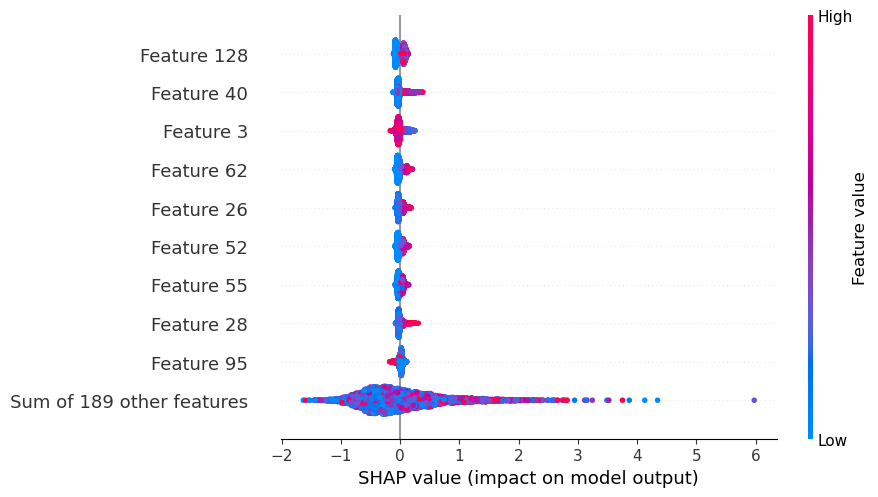

In [75]:
shap.plots.beeswarm(shap_values)

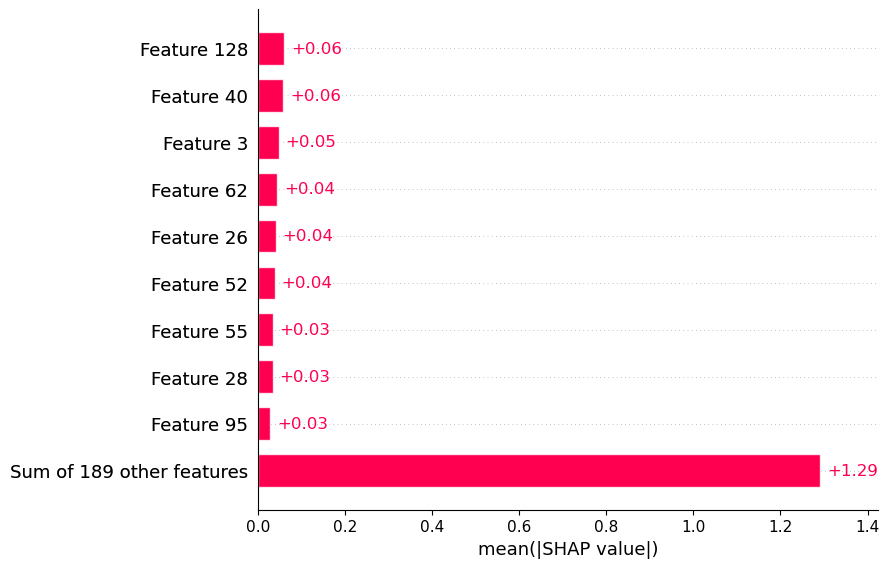

In [76]:
shap.plots.bar(shap_values)